# **Import Package**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import re

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

Mounted at /content/drive


import library yang di perlukan

# **Data Preparation**

In [2]:
df_movie = pd.read_csv("/content/drive/MyDrive/DBS/ML TERAPAN/ML Terapan 2/Data/movies.csv")
df_rating = pd.read_csv("/content/drive/MyDrive/DBS/ML TERAPAN/ML Terapan 2/Data/ratings.csv")

Membaca data, df_movie untuk data daftar film dengan movieId sebagai index dan df_rating untuk data user memberi rating dengan userId sebagai index

In [3]:
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Membaca 5 data teratas dari data daftar film

In [4]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Membaca 5 data teratas dari rating user

# **Pre-Processing Data**

## Data Undertand

In [5]:
movieShape = df_movie.shape
ratingShape = df_rating.shape

print(f'Ukuran dari data movie baris: {movieShape[0]} dan Kolom: {movieShape[1]}')
print(f'Ukuran dari data rating baris: {ratingShape[0]} dan Kolom: {ratingShape[1]}')

Ukuran dari data movie baris: 9742 dan Kolom: 3
Ukuran dari data rating baris: 100836 dan Kolom: 4


In [6]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Terdapat 2 variabel pada data movie, keduanya merupakan kategorik

In [7]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Terdapat 3 variabel pada data rating, dengan ketiganya merupakan data numerik

In [8]:
df_movie.isna().sum()

,0
movieId,0
title,0
genres,0


Tidak terdapat data kosong pada data movie

In [9]:
df_rating.isna().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


Tidak terdapat data kosong pada data rating

In [10]:
df_movie.duplicated().sum()

np.int64(0)

Tidak terdapat duplikasi data pada data movie

In [11]:
df_rating.duplicated().sum()

np.int64(0)

Tidak terdapat data duplikasi pada data rating

In [12]:
print('Jumlah userID: ', len(df_rating.userId.unique()))
print('Jumlah movieId: ', len(df_rating.movieId.unique()))
print('Jumlah data rating: ', len(df_rating))

Jumlah userID:  610
Jumlah movieId:  9724
Jumlah data rating:  100836


Terdapat 610 user yang melakukan penilaian, dari 9.724 film dengan total dari data rating 100.836

## EDA

In [13]:
df_rating.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Deskripsi statistika terkait data rating

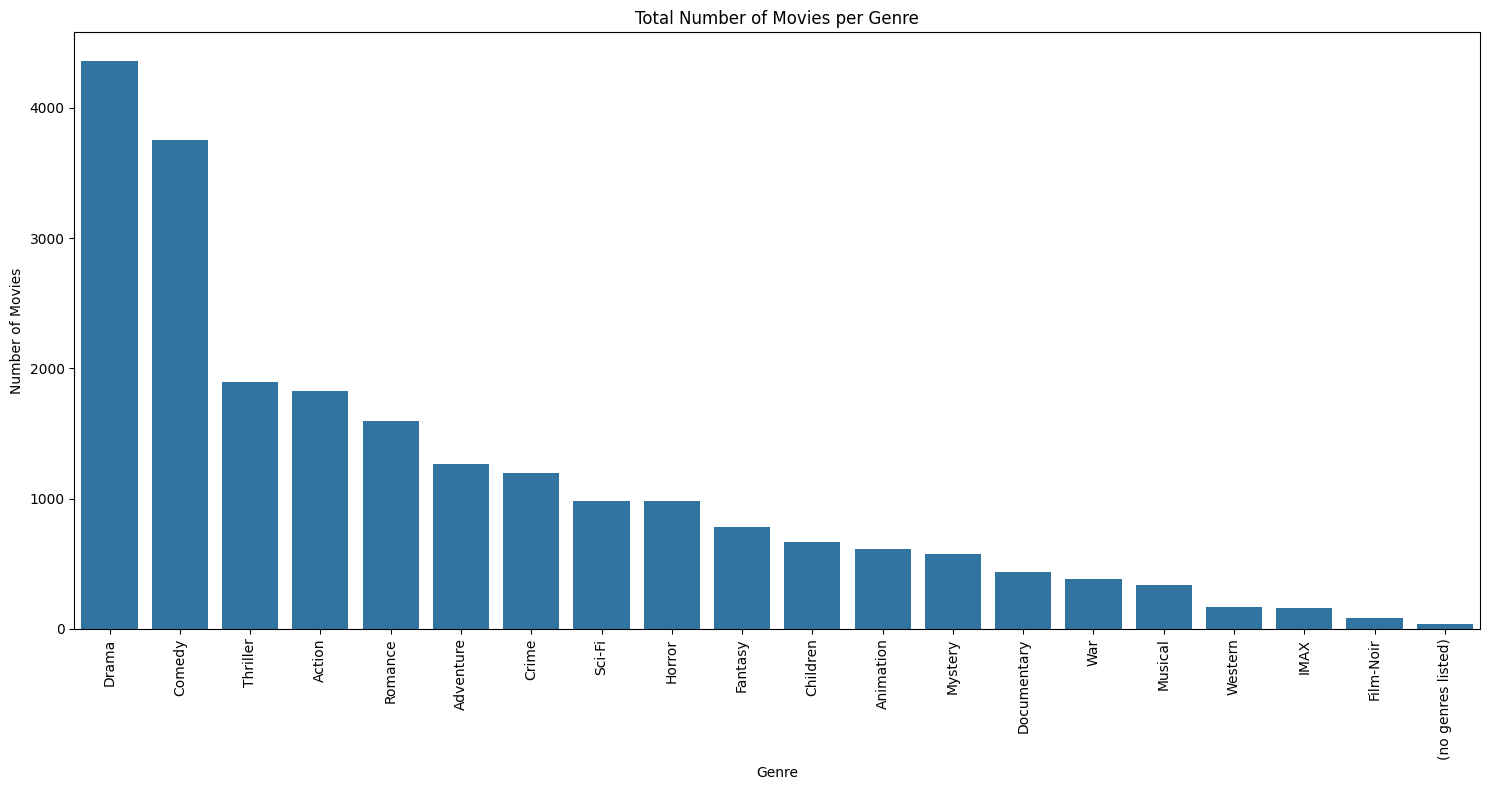

In [14]:
genres = df_movie['genres'].str.get_dummies('|').sum().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x=genres.index, y=genres.values)
plt.title('Total Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Melihat sebaran genre film

## Data Preparation

In [15]:
def clean(text):
  text = text.lower()
  text = re.sub(r'\|', ' ', text)
  return text

Mempersiapkan pembersihan data

In [16]:
df_movie_clean = df_movie.copy()
df_movie_clean['genres'] = df_movie_clean['genres'].apply(clean)
df_movie_clean.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


Data genre dibersihkan

In [17]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df_movie_clean['genres'])

Melakukan vektorisasi dengan TF-IDF

In [18]:
min_rating = df_rating['rating'].min()
max_rating = df_rating['rating'].max()

Menghitung max dan min nilai rating

In [19]:
unique_movie_ids = df_rating['movieId'].unique()
movie_to_index = {movie_id: index for index, movie_id in enumerate(unique_movie_ids)}

unique_user_ids = df_rating['userId'].unique()
user_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}

# Apply the mapping to the original dataframe before splitting
df_rating['userId_mapped'] = df_rating['userId'].map(user_to_index)
df_rating['movieId_mapped'] = df_rating['movieId'].map(movie_to_index)

Mempersiapkan data sebelum masuk kedalam model

In [20]:
x = df_rating[['userId_mapped', 'movieId_mapped']] # Use mapped IDs
y = df_rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Mempersiapkan data x dan y, lalu dilakukan splitting

# Training

In [21]:
similarity = cosine_similarity(tfidf)
print(similarity)

[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


Melakukan perhitungan similaritas pada tabel movie

In [22]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

Membangun model rekomendasi

In [24]:
num_users = len(df_rating.userId.unique())
movie_len = len(df_movie)
model = RecommenderNet(num_users, movie_len, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Melakukan compiling model

In [25]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 50,
    callbacks = [early_stopping_cb],
    validation_data = (X_test, y_test)
)

Epoch 1/50
5042/5042 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - loss: 0.6504 - root_mean_squared_error: 0.2443 - val_loss: 0.6139 - val_root_mean_squared_error: 0.2092
Epoch 2/50
5042/5042 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - loss: 0.6099 - root_mean_squared_error: 0.2027 - val_loss: 0.6091 - val_root_mean_squared_error: 0.2039
Epoch 3/50
5042/5042 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 0.6039 - root_mean_squared_error: 0.1973 - val_loss: 0.6075 - val_root_mean_squared_error: 0.2019
Epoch 4/50
5042/5042 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - loss: 0.6000 - root_mean_squared_error: 0.1942 - val_loss: 0.6071 - val_root_mean_squared_error: 0.2015
Epoch 5/50
5042/5042 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - loss: 0.5986 - root_mean_squared_error: 0.1909 - val_loss: 0.6071 - val_root_mean_squared_error: 0.2012
Epoch 6/50
5042/5042 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - loss: 0.5980 - root_mean_squared_error: 0.1913 - val_loss: 0.6065 - val_root_mean_squared_error: 0.2003
Epoch 7/50
5042/5042 ━━━━━━━

Melakukan training

# Evaluasi

In [40]:
def precision_at_k(similarity, df_movie_clean, k=5, num_eval_movies=100):
    num_movies = similarity.shape[0]
    random_movie_indices = np.random.choice(num_movies, num_eval_movies, replace=False)
    total_precision = 0

    genre_sets = [
        set(genres.split()) if pd.notnull(genres) else set()
        for genres in df_movie_clean['genres']
    ]

    for target_idx in random_movie_indices:
        similarity_scores = similarity[target_idx]
        sorted_indices = np.argsort(similarity_scores)[::-1]
        # Exclude the target movie itself
        recommended_indices = [i for i in sorted_indices if i != target_idx][:k]

        if not recommended_indices:
            continue  # Skip if no recommendations are made

        target_genres = genre_sets[target_idx]

        # Define "relevant" recommendations based on shared genres
        relevant_recommended_count = 0
        for rec_idx in recommended_indices:
            if len(target_genres.intersection(genre_sets[rec_idx])) > 0:
                relevant_recommended_count += 1

        total_precision += relevant_recommended_count / k

    return total_precision / num_eval_movies if num_eval_movies > 0 else 0

precision_value = precision_at_k(similarity, df_movie_clean, k=5, num_eval_movies=100)
print(f"Precision@5: {precision_value}")

Precision@5: 1.0


Evaluasi model content based filtering dengan recall@5

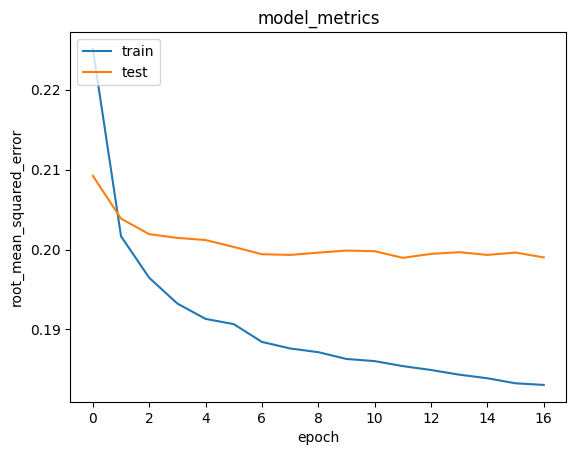

In [26]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Melihat grafik training dan testing

# Inference

In [41]:
def find_similar_movies(movie_id, num_similar=10):
    # Find the index of the given movie_id
    try:
        movie_index = df_movie_clean[df_movie_clean['movieId'] == movie_id].index[0]
    except IndexError:
        print(f"Movie ID {movie_id} not found in the dataset.")
        return pd.DataFrame()

    # Get the similarity scores for this movie with all other movies
    similarity_scores = list(enumerate(similarity[movie_index]))

    # Sort the movies based on similarity scores in descending order
    sorted_similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the most similar movies (exclude the movie itself)
    top_movie_indices = [i[0] for i in sorted_similarity_scores[1:num_similar+1]]

    # Get the movie details for the similar movies
    similar_movies = df_movie_clean.iloc[top_movie_indices][['title', 'genres']]

    return similar_movies

# Find similar movies for a movie with movieId 50 (Usual Suspects, The)
movie_id_to_find_similar = 50
similar_movies = find_similar_movies(movie_id_to_find_similar, num_similar=10)

if not similar_movies.empty:
    print(f"\nTop 10 similar movies for Movie ID {movie_id_to_find_similar} ({df_movie_clean[df_movie_clean['movieId'] == movie_id_to_find_similar]['title'].values[0]}):")
similar_movies



Top 10 similar movies for Movie ID 50 (Usual Suspects, The (1995)):


,title,genres
826,Dial M for Murder (1954),crime mystery thriller
828,Reservoir Dogs (1992),crime mystery thriller
831,Basic Instinct (1992),crime mystery thriller
1250,Switchback (1997),crime mystery thriller
1945,Following (1998),crime mystery thriller
3329,Frantic (1988),crime mystery thriller
3991,Red Dragon (2002),crime mystery thriller
5294,Sherlock Holmes: Terror by Night (1946),crime mystery thriller
5296,Sherlock Holmes and the Secret Weapon (1942),crime mystery thriller
5337,Murder on the Orient Express (1974),crime mystery thriller


Melakukan inference pada content based

In [29]:
def recommend_for_user(user_id, num_recommendations=10):
  user_index = user_to_index.get(user_id)
  if user_index is None:
    print(f"User ID {user_id} not found in the training data.")
    return pd.DataFrame()

  movies_not_rated_by_user = df_movie_clean[~df_movie_clean['movieId'].isin(df_rating[df_rating['userId'] == user_id]['movieId'])]['movieId'].values
  movies_not_rated_mapped = [movie_to_index[movie_id] for movie_id in movies_not_rated_by_user if movie_id in movie_to_index]

  if not movies_not_rated_mapped:
      print(f"User ID {user_id} has rated all movies or no new movies are available for recommendation.")
      return pd.DataFrame()

  user_tensor = tf.constant([user_index] * len(movies_not_rated_mapped), dtype=tf.int32)
  movies_tensor = tf.constant(movies_not_rated_mapped, dtype=tf.int32)

  # Stack the user and movie tensors into a single input tensor
  model_input = tf.stack([user_tensor, movies_tensor], axis=1)

  # Make predictions
  predicted_ratings = model.predict(model_input)

  # Get the top recommended movie indices
  top_movie_indices = np.argsort(predicted_ratings.flatten())[::-1][:num_recommendations]

  # Map the recommended movie indices back to original movie IDs
  index_to_movie = {index: movie_id for movie_id, index in movie_to_index.items()}
  recommended_movie_ids = [index_to_movie[movies_not_rated_mapped[i]] for i in top_movie_indices]

  # Get the movie details for the recommended movies
  recommended_movies = df_movie_clean[df_movie_clean['movieId'].isin(recommended_movie_ids)]

  return recommended_movies[['title', 'genres']]

# Example usage:
user_id_to_recommend_for = 1 # Replace with the desired user ID
recommendations = recommend_for_user(user_id_to_recommend_for, num_recommendations=10)

if not recommendations.empty:
    print(f"Top 10 movie recommendations for User ID {user_id_to_recommend_for}:")
recommendations

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Top 10 movie recommendations for User ID 1:


,title,genres
98,Taxi Driver (1976),crime drama thriller
602,Dr. Strangelove or: How I Learned to Stop Worr...,comedy war
841,"Streetcar Named Desire, A (1951)",drama
906,Lawrence of Arabia (1962),adventure drama war
918,Ran (1985),drama war
924,"Grand Day Out with Wallace and Gromit, A (1989)",adventure animation children comedy sci-fi
937,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",drama
2320,Jeremiah Johnson (1972),western
2328,All About My Mother (Todo sobre mi madre) (1999),drama
2593,"Hustler, The (1961)",drama


Melakukan inference pada user-based